# Daily Climate time series data
Daily climate data in the city of Delhi from 2013 to 2017

-Raafi Dimas 12/07/2021

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from keras.layers import Dense, LSTM

from google.colab import drive
drive.mount('/content/drive/',  force_remount=True)

Mounted at /content/drive/


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Datacolab/DailyDelhiClimateTrain.csv')
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
# Cek null values

data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

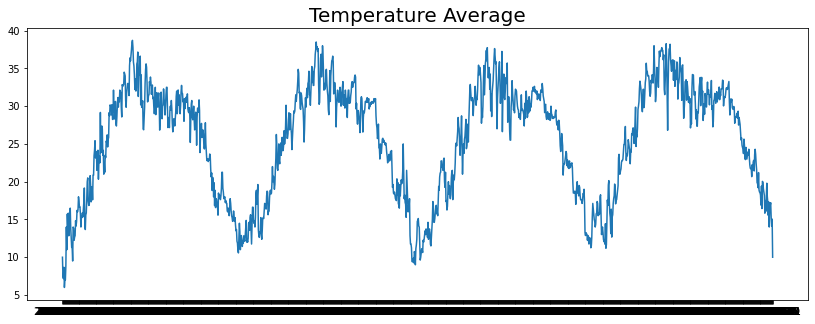

In [ ]:
dates = data_train['date'].values
temp = data_train['meantemp'].values

plt.figure(figsize=(14,5))
plt.plot(dates, temp)
plt.title('Temperature Average',
          fontsize = 20);

In [ ]:
# visualisasi humadity dengan slider

fig = px.line(data_train, x=data_train.index, y='humidity', title='Humidity with slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
# Test untuk stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(data_train['humidity'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

# KPSS Test
stats, p, lags, critical_values = kpss(data_train['humidity'], 'ct')
print(f'KPSS Test Statistics: {stats}')
print(f'p-value: {p}')

if p<0.05:
      print('Series is not Stationary')
else:
      print('Series is Stationary')

ADF Statistic: -3.675576919163339
p-value: 0.004470100478130758
Series is Stationary
KPSS Test Statistics: 0.06251203730075192
p-value: 0.1
Series is Stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



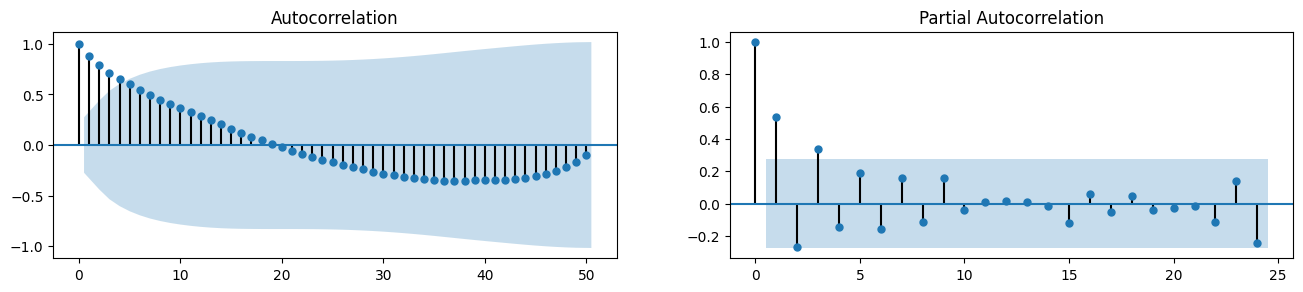

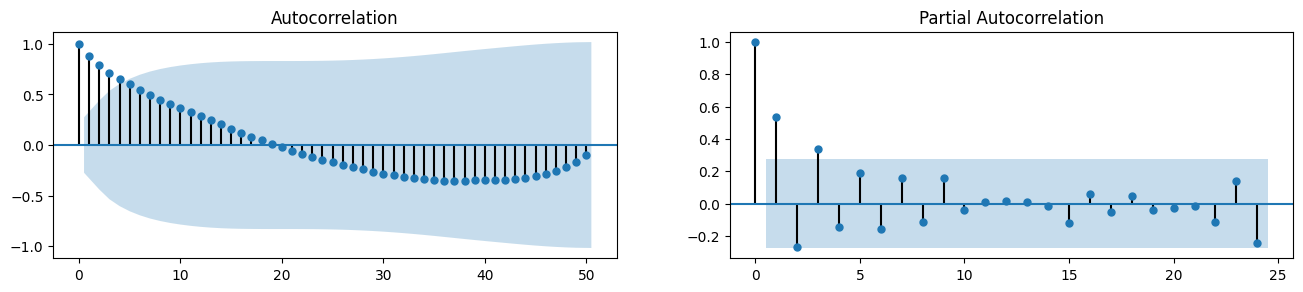

In [ ]:
# Autocorrelation testing
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(data_train['humidity'], nlags=50)
pacf_50 = pacf(data_train['humidity'], nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(acf_50, lags=50, ax=axes[0])
plot_pacf(pacf_50, lags=24, ax=axes[1])

In [ ]:
#format ke model

def window_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds. shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)


In [ ]:
# dengan 2 layer LSTM

train_set = window_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
# Optimizer

optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-04, momentum= 0.9)
model.compile(loss = tf.keras.losses.Huber(),
                optimizer = optimizer,
                 metrics = ["mae"])

history = model.fit(train_set, epochs = 100)

Epoch 1/100
15/15 [==============================] - 6s 101ms/step - loss: 25.4686 - mae: 25.9686
Epoch 2/100
15/15 [==============================] - 2s 101ms/step - loss: 25.3090 - mae: 25.8090
Epoch 3/100
15/15 [==============================] - 2s 96ms/step - loss: 25.1145 - mae: 25.6145
Epoch 4/100
15/15 [==============================] - 2s 96ms/step - loss: 24.9646 - mae: 25.4646
Epoch 5/100
15/15 [==============================] - 2s 96ms/step - loss: 24.8278 - mae: 25.3278
Epoch 6/100
15/15 [==============================] - 2s 96ms/step - loss: 24.6798 - mae: 25.1798
Epoch 7/100
15/15 [==============================] - 2s 100ms/step - loss: 24.5168 - mae: 25.0168
Epoch 8/100
15/15 [==============================] - 2s 98ms/step - loss: 24.3329 - mae: 24.8329
Epoch 9/100
15/15 [==============================] - 2s 96ms/step - loss: 24.1278 - mae: 24.6278
Epoch 10/100
15/15 [==============================] - 2s 97ms/step - loss: 23.8962 - mae: 24.3962
Epoch 11/100
15/15 [======

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') <0.2):
      print("\nMAE telah mencapai nilai terkecil!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history1 = model.fit(train_set, epochs = 10, callbacks=[callbacks])

Epoch 1/10
15/15 [==============================] - 2s 100ms/step - loss: 1.1184 - mae: 1.5483
Epoch 2/10
15/15 [==============================] - 2s 101ms/step - loss: 1.0906 - mae: 1.5175
Epoch 3/10
15/15 [==============================] - 2s 99ms/step - loss: 1.0956 - mae: 1.5217
Epoch 4/10
15/15 [==============================] - 2s 98ms/step - loss: 1.1316 - mae: 1.5620
Epoch 5/10
15/15 [==============================] - 2s 97ms/step - loss: 1.0970 - mae: 1.5284
Epoch 6/10
15/15 [==============================] - 2s 98ms/step - loss: 1.0673 - mae: 1.4964
Epoch 7/10
15/15 [==============================] - 2s 99ms/step - loss: 1.0959 - mae: 1.5265
Epoch 8/10
15/15 [==============================] - 2s 97ms/step - loss: 1.0693 - mae: 1.4928
Epoch 9/10
15/15 [==============================] - 2s 96ms/step - loss: 1.0540 - mae: 1.4810
Epoch 10/10
15/15 [==============================] - 2s 96ms/step - loss: 1.0742 - mae: 1.4950
